# DEEP NEURAL NETWORKS - ASSIGNMENT 2: CNN FOR IMAGE CLASSIFICATION

## Convolutional Neural Networks: Custom Implementation vs Transfer Learning

STUDENT INFORMATION (REQUIRED - DO NOT DELETE)

BITS ID: 2025AA05656

Name: SHREYA SRIRAM

Email: 2025aa05656@wilp.bits-pilani.ac.in

Date: 3-Feb-2026

In [52]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import time
import json
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from collections import Counter
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, applications, optimizers, backend as K
import os
import seaborn as sns

In [53]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### 1.1 Dataset Selection and Loading

TODO: Load your chosen dataset

In [54]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs', 
    split=['train[:85%]', 'train[85%:]'], 
    as_supervised=True, 
    with_info=True,
    try_gcs=True  
)

In [55]:
label_counts = Counter()
for image, label in tfds.as_numpy(ds_train):
    label_counts[int(label)] += 1

min_c = min(label_counts.values())
max_c = max(label_counts.values())
avg_c = sum(label_counts.values()) / len(label_counts)

2026-02-07 19:41:45.074256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [56]:
# REQUIRED: Fill in these metadata fields
dataset_name = "Cats VS Dogs"
dataset_source = "Tensorflow datasets"
n_samples = int(ds_info.splits['train'].num_examples)  # TODO: Total number of images
n_classes = int(ds_info.features['label'].num_classes)  # TODO: Number of classes
samples_per_class = f"min: {min_c}, max: {max_c}, avg: {avg_c:.1f}"
image_shape = [224, 224, 3]  # [height, width, channels]
problem_type = "classification"

In [57]:
# Primary metric selection
primary_metric = "accuracy"
metric_justification = """Accuracy is chosen because this is a balanced, binary classification problem where both classes have representation and the typical misclassification costs are symmetric. accuracy therefore gives a direct measure of overall correctness"""

In [58]:
print("DATASET INFORMATION")
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Total Samples: {n_samples}")
print(f"Number of Classes: {n_classes}")
print(f"Samples per Class: {samples_per_class}")
print(f"Image Shape: {image_shape}")
print(f"Primary Metric: {primary_metric}")
print(f"Metric Justification: {metric_justification}")

DATASET INFORMATION
Dataset: Cats VS Dogs
Source: Tensorflow datasets
Total Samples: 23262
Number of Classes: 2
Samples per Class: min: 9835, max: 9938, avg: 9886.5
Image Shape: [224, 224, 3]
Primary Metric: accuracy
Metric Justification: Accuracy is chosen because this is a balanced, binary classification problem where both classes have representation and the typical misclassification costs are symmetric. accuracy therefore gives a direct measure of overall correctness


### 1.2 Data Exploration and Visualization

- TODO: Show sample images from each class
- TODO: Plot class distribution
- TODO: Display image statistics

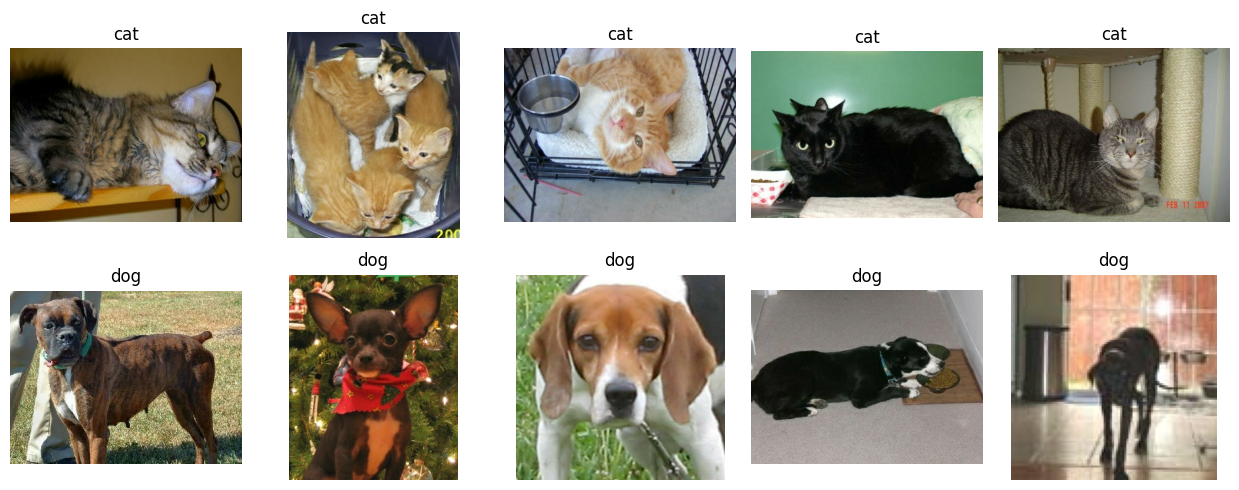

In [59]:
class_names = ds_info.features['label'].names  

def show_samples_per_class(ds, class_names, samples_per_class=5):
    collected = {i: [] for i in range(len(class_names))}

    for image, label in ds:
        lbl = int(label.numpy())
        if len(collected[lbl]) < samples_per_class:
            collected[lbl].append(image)
        if all(len(collected[i]) == samples_per_class for i in collected):
            break

    plt.figure(figsize=(samples_per_class * 2.5, len(class_names) * 2.5))
    for cls_idx, cls_name in enumerate(class_names):
        for j, img in enumerate(collected[cls_idx]):
            plt.subplot(len(class_names), samples_per_class,
                        cls_idx * samples_per_class + j + 1)
            plt.imshow(img.numpy())
            plt.axis('off')
            plt.title(cls_name)
    plt.tight_layout()
    plt.show()

show_samples_per_class(ds_train, class_names)


Class counts: {'dog': 9835, 'cat': 9938}


2026-02-07 19:41:47.783520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


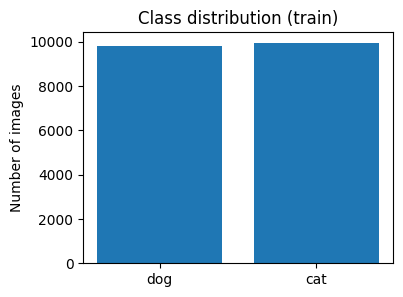

In [60]:
label_counts = Counter()
for _, label in ds_train:
    label_counts[int(label.numpy())] += 1

print("Class counts:", {class_names[k]: v for k, v in label_counts.items()})

plt.figure(figsize=(4, 3))
plt.bar(
    [class_names[i] for i in label_counts.keys()],
    [label_counts[i] for i in label_counts.keys()]
)
plt.ylabel("Number of images")
plt.title("Class distribution (train)")
plt.show()


Class counts: {'cat': 1720, 'dog': 1769}


2026-02-07 19:41:48.322888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


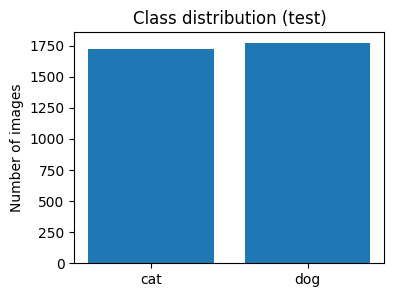

In [61]:
label_counts = Counter()
for _, label in ds_test:
    label_counts[int(label.numpy())] += 1

print("Class counts:", {class_names[k]: v for k, v in label_counts.items()})

plt.figure(figsize=(4, 3))
plt.bar(
    [class_names[i] for i in label_counts.keys()],
    [label_counts[i] for i in label_counts.keys()]
)
plt.ylabel("Number of images")
plt.title("Class distribution (test)")
plt.show()

In [64]:
def show_image_stats(ds, num_samples=1000):
    means, stds = [], []
    shapes = []
    for i, (img, _) in enumerate(ds):
        if i >= num_samples:
            break
        img_f = tf.cast(img, tf.float32) / 255.0
        means.append(tf.reduce_mean(img_f).numpy())
        stds.append(tf.math.reduce_std(img_f).numpy())
        shapes.append(img.shape)

    print(f"Samples used: {len(means)}")
    print(f"Mean pixel value: {np.mean(means):.4f}")
    print(f"Std pixel value:  {np.mean(stds):.4f}")
    if shapes:
        print(f"Example original shape: {shapes[0]}")

show_image_stats(ds_train, 1000)


Samples used: 1000
Mean pixel value: 0.4527
Std pixel value:  0.2327
Example original shape: (262, 350, 3)


In [65]:
def show_image_stats(ds, num_samples=1000):
    means, stds = [], []
    shapes = []
    for i, (img, _) in enumerate(ds):
        if i >= num_samples:
            break
        img_f = tf.cast(img, tf.float32) / 255.0
        means.append(tf.reduce_mean(img_f).numpy())
        stds.append(tf.math.reduce_std(img_f).numpy())
        shapes.append(img.shape)

    print(f"Samples used: {len(means)}")
    print(f"Mean pixel value: {np.mean(means):.4f}")
    print(f"Std pixel value:  {np.mean(stds):.4f}")
    if shapes:
        print(f"Example original shape: {shapes[0]}")

show_image_stats(ds_test, 1000)

Samples used: 1000
Mean pixel value: 0.4466
Std pixel value:  0.2337
Example original shape: (483, 416, 3)


### 1.3 Data Preprocessing
- TODO: Resize images to consistent size
- TODO: Normalize pixel values
- TODO: Split into train/test (90/10 or 85/15)

In [66]:
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image, tf.one_hot(label, depth=2)  


In [67]:
train_ds = (ds_train
            .map(preprocess, num_parallel_calls=AUTOTUNE)
            .shuffle(10000)
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE))

test_ds = (ds_test
           .map(preprocess, num_parallel_calls=AUTOTUNE)
           .batch(BATCH_SIZE)
           .prefetch(AUTOTUNE))

In [68]:
# REQUIRED: Document your split
train_test_ratio = "85/15"
train_samples = len(ds_train)  # TODO: Number of training samples
test_samples = len(ds_test)  # TODO: Number of test samples

In [69]:
print(f"\nTrain/Test Split: {train_test_ratio}")
print(f"Training Samples: {train_samples}")
print(f"Test Samples: {test_samples}")


Train/Test Split: 85/15
Training Samples: 19773
Test Samples: 3489


### 2.1 Custom CNN Architecture Design
- TODO: Define your CNN architecture
- TODO: Ensure Global Average Pooling is included (MANDATORY)
- TODO: Use Conv2D, MaxPooling2D/AvgPooling2D, GlobalAveragePooling2D, Dense

In [70]:
def build_custom_cnn(input_shape, n_classes):
    """
    Build custom CNN architecture
    
    Args:
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes
    
    Returns:
        model: compiled CNN model
    """
    # TODO: Implement your CNN architecture
    # Must include Global Average Pooling
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                      input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # MANDATORY: Global Average Pooling (NO Flatten)
        layers.GlobalAveragePooling2D(),

        # Output layer with Softmax
        layers.Dense(n_classes, activation='softmax')
    ])
    model.summary()
    return model

In [71]:
# TODO: Create model instance
custom_cnn = build_custom_cnn(image_shape, n_classes)

/Users/shreya/miniconda3/envs/tf_cnn/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,506 (365.26 KB)

 Trainable params: 93,506 (365.26 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
# Training configuration
custom_cnn_learning_rate = 0.001
custom_cnn_epochs = 20
custom_cnn_batch_size = 32
custom_cnn_optimizer = "Adam"
custom_cnn_loss = "categorical_crossentropy",
custom_cnn_metrics = ["accuracy"]

In [73]:
# TODO: Compile model
# For Keras: model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# For PyTorch: define optimizer and loss function
custom_cnn.compile(
        optimizer=optimizers.Adam(learning_rate=custom_cnn_learning_rate),
        loss=custom_cnn_loss,
        metrics=custom_cnn_metrics
    )

### 2.2 Train Custom CNN

In [74]:
print("\nCUSTOM CNN TRAINING")
# Track training time
custom_cnn_start_time = time.time()


CUSTOM CNN TRAINING


In [75]:
# TODO: Train your model
# For Keras: history = custom_cnn.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)
# For PyTorch: write training loop
history = custom_cnn.fit(
    train_ds,
    epochs=custom_cnn_epochs,
    batch_size=custom_cnn_batch_size
)

Epoch 1/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 71s 97ms/step - accuracy: 0.5936 - loss: 0.6553
Epoch 2/20


2026-02-07 20:21:59.539924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2294: Filling up shuffle buffer (this may take a while): 7743 of 10000
2026-02-07 20:22:00.104580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


618/618 ━━━━━━━━━━━━━━━━━━━━ 61s 80ms/step - accuracy: 0.6583 - loss: 0.6120
Epoch 3/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 52s 81ms/step - accuracy: 0.6882 - loss: 0.5842
Epoch 4/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 54s 85ms/step - accuracy: 0.7078 - loss: 0.5641
Epoch 5/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 59s 92ms/step - accuracy: 0.7232 - loss: 0.5499
Epoch 6/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 59s 93ms/step - accuracy: 0.7313 - loss: 0.5402
Epoch 7/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 59s 92ms/step - accuracy: 0.7363 - loss: 0.5288
Epoch 8/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 60s 93ms/step - accuracy: 0.7465 - loss: 0.5235
Epoch 9/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 62s 96ms/step - accuracy: 0.7553 - loss: 0.5055
Epoch 10/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 59s 91ms/step - accuracy: 0.7611 - loss: 0.4972
Epoch 11/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 59s 91ms/step - accuracy: 0.7678 - loss: 0.4911
Epoch 12/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 59s 91ms/step - accuracy: 0.7762 - loss: 0.4769
Epoch 13/20
618/618 ━━━━━━━━━━━━━━━━━━━━

2026-02-07 21:42:29.257887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2294: Filling up shuffle buffer (this may take a while): 2434 of 10000
2026-02-07 21:42:33.554628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


618/618 ━━━━━━━━━━━━━━━━━━━━ 3345s 2s/step - accuracy: 0.7994 - loss: 0.4402
Epoch 18/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 51s 79ms/step - accuracy: 0.8096 - loss: 0.4263
Epoch 19/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 52s 80ms/step - accuracy: 0.8089 - loss: 0.4219
Epoch 20/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 52s 82ms/step - accuracy: 0.8122 - loss: 0.4151


In [76]:
custom_cnn_training_time = time.time() - custom_cnn_start_time

In [77]:
# REQUIRED: Track initial and final loss
custom_cnn_initial_loss = float(history.history['loss'][0]) # TODO: Get from training history (first epoch)
custom_cnn_final_loss = float(history.history['loss'][-1])  # TODO: Get from training history (last epoch)

In [78]:
print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")

Training completed in 7446.20 seconds
Initial Loss: 0.6553
Final Loss: 0.4151


In [79]:
print("\nCUSTOM CNN EVALUATION")


CUSTOM CNN EVALUATION


### 2.3 Evaluate Custom CNN
- TODO: Make predictions on test set
- TODO: Calculate all 4 required metrics

In [80]:
cnn_y_true = []
cnn_y_pred = []

for images, labels in test_ds:
    probs = custom_cnn.predict(images, verbose=0)
    cnn_y_pred.extend(np.argmax(probs, axis=1))          # predicted class indices
    cnn_y_true.extend(np.argmax(labels.numpy(), axis=1)) # true class indices (one-hot -> int)

cnn_y_true = np.array(cnn_y_true)
cnn_y_pred = np.array(cnn_y_pred)

2026-02-07 22:24:51.249730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [81]:
# CRITICAL: These MUST be calculated from your actual results
# DO NOT submit with 0.0 values - autograder will detect this
# REQUIRED: Calculate all 4 metrics

custom_cnn_accuracy = accuracy_score(cnn_y_true, cnn_y_pred)
custom_cnn_precision = precision_score(cnn_y_true, cnn_y_pred, average='macro')
custom_cnn_recall = recall_score(cnn_y_true, cnn_y_pred, average='macro')
custom_cnn_f1 = f1_score(cnn_y_true, cnn_y_pred, average='macro')

In [82]:
print("\nCustom CNN Performance:")
print(f"Accuracy:  {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall:    {custom_cnn_recall:.4f}")
print(f"F1-Score:  {custom_cnn_f1:.4f}")


Custom CNN Performance:
Accuracy:  0.8246
Precision: 0.8262
Recall:    0.8241
F1-Score:  0.8242


### 2.4 Visualize Custom CNN Results
- TODO: Plot training loss curve
- TODO: Plot confusion matrix
- TODO: Show sample predictions

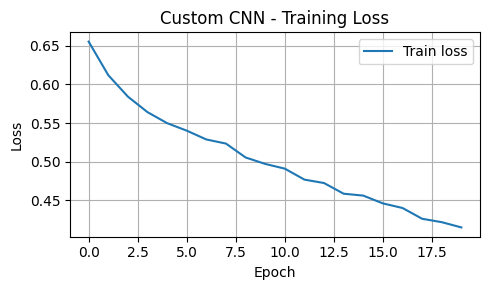

In [83]:
plt.figure(figsize=(5, 3))
plt.plot(custom_cnn.history.history['loss'], label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Custom CNN - Training Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [84]:
custom_cnn_confusion_matrix = confusion_matrix(cnn_y_true, cnn_y_pred)  
print("Confusion matrix:\n", custom_cnn_confusion_matrix)

Confusion matrix:
 [[1355  365]
 [ 247 1522]]


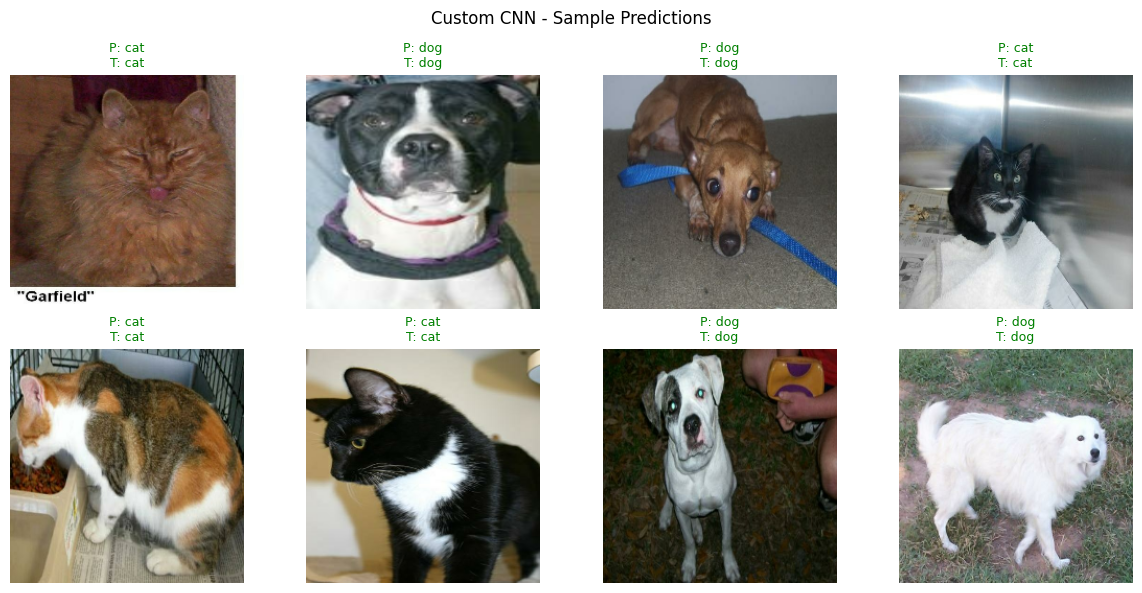

In [85]:

images_batch, labels_batch = next(iter(test_ds))

probs_batch = custom_cnn.predict(images_batch, verbose=0)
pred_indices = np.argmax(probs_batch, axis=1)
true_indices = np.argmax(labels_batch.numpy(), axis=1)

plt.figure(figsize=(12, 6))
num_show = min(8, images_batch.shape[0])

for i in range(num_show):
    plt.subplot(2, 4, i + 1)
    img = images_batch[i].numpy()
    plt.imshow(img)
    plt.axis('off')
    pred_label = class_names[pred_indices[i]]
    true_label = class_names[true_indices[i]]
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f"P: {pred_label}\nT: {true_label}", color=color, fontsize=9)

plt.suptitle("Custom CNN - Sample Predictions", fontsize=12)
plt.tight_layout()
plt.show()


### 3.1 Load Pre-trained Model and Modify Architecture

In [86]:
print("\n" + "="*70)
print("TRANSFER LEARNING IMPLEMENTATION")


TRANSFER LEARNING IMPLEMENTATION


In [97]:
# TODO: Choose and load pre-trained model
pretrained_model_name = "ResNet50"
transfer_model_loss = "categorical_crossentropy"
transfer_model_metrics = ["accuracy"]
transfer_model_learning_rate = 0.001


In [98]:
def build_transfer_learning_model(base_model_name, input_shape, n_classes):
    """
    Build transfer learning model
    
    Args:
        base_model_name: string (ResNet18/ResNet50/VGG16/VGG19)
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes
    
    Returns:
        model: compiled transfer learning model
    """
    base_model = applications.ResNet50(
            include_top=False,
            weights="imagenet",
            input_shape=input_shape
        )
    base_model.trainable = False
    
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)          
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(n_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs, name=f"{base_model_name}_transfer")
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=transfer_model_learning_rate),
        loss=transfer_model_loss,
        metrics=transfer_model_metrics,
    )
    return model


In [99]:
# TODO: Create transfer learning model
transfer_model = build_transfer_learning_model(pretrained_model_name, image_shape, n_classes)

In [100]:
# REQUIRED: Count layers and parameters
frozen_layers = sum(1 for layer in transfer_model.layers if not layer.trainable) # TODO: Count frozen layers
trainable_layers = sum(1 for layer in transfer_model.layers if layer.trainable) # TODO: Count trainable layers
total_parameters = transfer_model.count_params() # TODO: Total parameters
trainable_parameters = int(
    np.sum([K.count_params(w) for w in transfer_model.trainable_weights])
)  # TODO: Trainable parameters only

In [101]:
print(f"Base Model: {pretrained_model_name}")
print(f"Frozen Layers: {frozen_layers}")
print(f"Trainable Layers: {trainable_layers}")
print(f"Total Parameters: {total_parameters:,}")
print(f"Trainable Parameters: {trainable_parameters:,}")
print(f"Using Global Average Pooling: YES")

Base Model: ResNet50
Frozen Layers: 1
Trainable Layers: 6
Total Parameters: 24,112,770
Trainable Parameters: 525,058
Using Global Average Pooling: YES


### 3.2 Train Transfer Learning Model

In [102]:
print("\nTraining Transfer Learning Model...")


Training Transfer Learning Model...


In [132]:
# Training configuration
tl_learning_rate = 0.001
tl_epochs = 20
tl_batch_size = 32
tl_optimizer = "Adam"

In [133]:
# Track training time
tl_start_time = time.time()

In [134]:
# TODO: Train model
transfer_model.fit(train_ds, epochs=tl_epochs, batch_size=tl_batch_size)
# For PyTorch: write training loop

Epoch 1/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 137s 217ms/step - accuracy: 0.5724 - loss: 0.7007
Epoch 2/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 180s 287ms/step - accuracy: 0.5744 - loss: 0.7025
Epoch 3/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 193s 308ms/step - accuracy: 0.5693 - loss: 0.7157
Epoch 4/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 189s 300ms/step - accuracy: 0.5717 - loss: 0.7146
Epoch 5/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 187s 297ms/step - accuracy: 0.5693 - loss: 0.7088
Epoch 6/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 193s 307ms/step - accuracy: 0.5768 - loss: 0.7029
Epoch 7/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 186s 296ms/step - accuracy: 0.5746 - loss: 0.7105
Epoch 8/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 190s 302ms/step - accuracy: 0.5685 - loss: 0.7192
Epoch 9/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 181s 287ms/step - accuracy: 0.5748 - loss: 0.7144
Epoch 10/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 192s 304ms/step - accuracy: 0.5746 - loss: 0.7047
Epoch 11/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 181s 287ms/step - accuracy: 0.5675 - loss: 0.7189
Epoch 12

In [135]:
tl_training_time = time.time() - tl_start_time

In [136]:
# REQUIRED: Track initial and final loss
tl_initial_loss = transfer_model.history.history['loss'][0]  # TODO: Get from training history (first epoch)
tl_final_loss = transfer_model.history.history['loss'][-1]  # TODO: Get from training history (last epoch)

In [137]:
print(f"Training completed in {tl_training_time:.2f} seconds")
print(f"Initial Loss: {tl_initial_loss:.4f}")
print(f"Final Loss: {tl_final_loss:.4f}")

Training completed in 3585.77 seconds
Initial Loss: 0.7007
Final Loss: 0.7216


### 3.3 Evaluate Transfer Learning Model
- TODO: Make predictions on test set
- TODO: Calculate all 4 required metrics

In [138]:
tf_y_true = []
tf_y_pred = []

for images, labels in test_ds:
    probs = transfer_model.predict(images, verbose=0)
    tf_y_pred.extend(np.argmax(probs, axis=1))       
    tf_y_true.extend(np.argmax(labels.numpy(), axis=1)) 
    
tf_y_true = np.array(tf_y_true)
tf_y_pred = np.array(tf_y_pred)

2026-02-08 00:14:58.865117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [139]:
# REQUIRED: Calculate all 4 metrics
tl_accuracy = accuracy_score(tf_y_true, tf_y_pred)
tl_precision = precision_score(tf_y_true, tf_y_pred, average='macro')
tl_recall = recall_score(tf_y_true, tf_y_pred, average='macro')
tl_f1 = f1_score(tf_y_true, tf_y_pred, average='macro')

In [140]:
print("\nTransfer Learning Performance:")
print(f"Accuracy:  {tl_accuracy:.4f}")
print(f"Precision: {tl_precision:.4f}")
print(f"Recall:    {tl_recall:.4f}")
print(f"F1-Score:  {tl_f1:.4f}")


Transfer Learning Performance:
Accuracy:  0.6523
Precision: 0.6537
Recall:    0.6529
F1-Score:  0.6520


### 3.4 Visualize Transfer Learning Results
- TODO: Plot training curves (loss and accuracy)
- TODO: Plot confusion matrix
- TODO: Show sample predictions

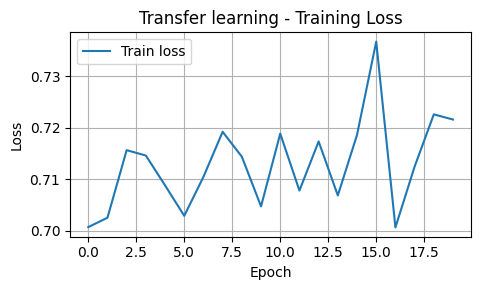

In [141]:
plt.figure(figsize=(5, 3))
plt.plot(transfer_model.history.history['loss'], label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Transfer learning - Training Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [142]:
tf_cm = confusion_matrix(tf_y_true, tf_y_pred)  
print("Confusion matrix:\n", tf_cm)

Confusion matrix:
 [[1189  531]
 [ 682 1087]]


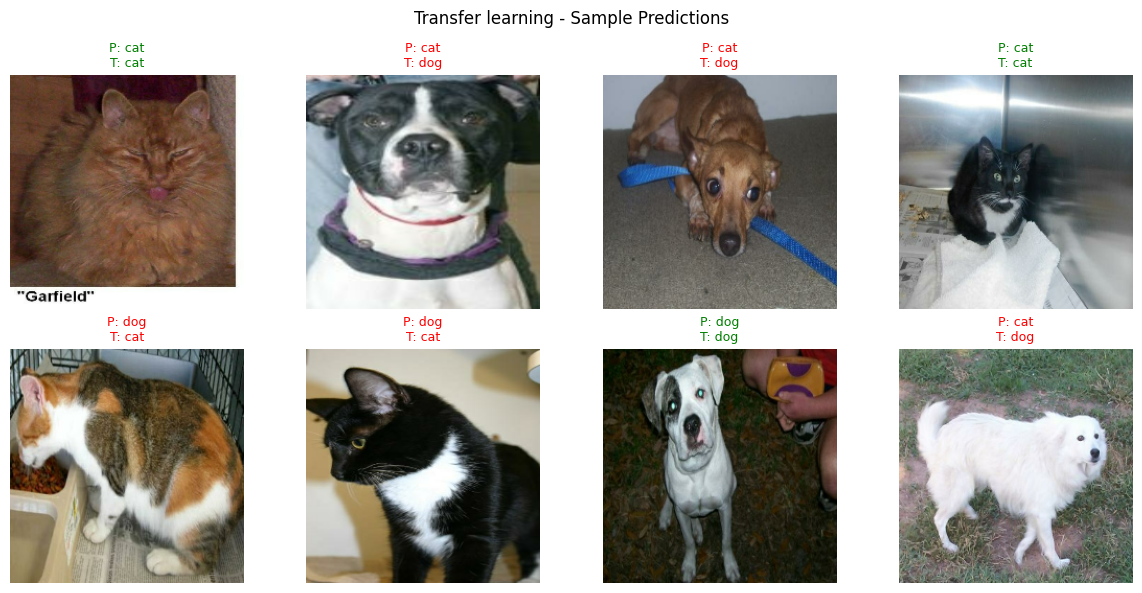

In [143]:

images_batch, labels_batch = next(iter(test_ds))

probs_batch = transfer_model.predict(images_batch, verbose=0)
pred_indices = np.argmax(probs_batch, axis=1)
true_indices = np.argmax(labels_batch.numpy(), axis=1)

plt.figure(figsize=(12, 6))
num_show = min(8, images_batch.shape[0])

for i in range(num_show):
    plt.subplot(2, 4, i + 1)
    img = images_batch[i].numpy()
    plt.imshow(img)
    plt.axis('off')
    pred_label = class_names[pred_indices[i]]
    true_label = class_names[true_indices[i]]
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f"P: {pred_label}\nT: {true_label}", color=color, fontsize=9)

plt.suptitle("Transfer learning - Sample Predictions", fontsize=12)
plt.tight_layout()
plt.show()


### 4.1 Metrics Comparison

In [144]:
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)', 'Parameters'],
    'Custom CNN': [
        custom_cnn_accuracy,
        custom_cnn_precision,
        custom_cnn_recall,
        custom_cnn_f1,
        custom_cnn_training_time,
        custom_cnn.count_params()  # TODO: Fill with custom CNN total parameters
    ],
    'Transfer Learning': [
        tl_accuracy,
        tl_precision,
        tl_recall,
        tl_f1,
        tl_training_time,
        transfer_model.count_params()  # TODO: Fill with transfer learning model total parameters
    ]
})

In [145]:
print(comparison_df.to_string(index=False))

           Metric   Custom CNN  Transfer Learning
         Accuracy     0.824592       6.523359e-01
        Precision     0.826195       6.536531e-01
           Recall     0.824082       6.528753e-01
         F1-Score     0.824189       6.520385e-01
Training Time (s)  7446.203086       3.585770e+03
       Parameters 93506.000000       2.411277e+07


### 4.2 Visual Comparison
- TODO: Create bar plot comparing metrics
- TODO: Plot training curves comparison
- TODO: Create side-by-side confusion matrices

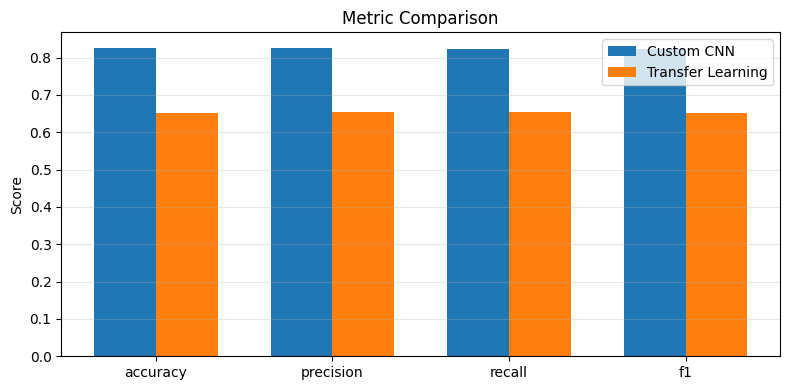

In [146]:
cnn_metrics = {"accuracy": custom_cnn_accuracy, "precision": custom_cnn_precision, "recall": custom_cnn_recall, "f1": custom_cnn_f1}
tf_metrics = {"accuracy": tl_accuracy, "precision": tl_precision, "recall": tl_recall, "f1": tl_f1}

metric_names = list(cnn_metrics.keys())
vals_a = [cnn_metrics[m] for m in metric_names]
vals_b = [tf_metrics[m] for m in metric_names]

x = np.arange(len(metric_names))
width = 0.35

plt.figure(figsize=(8, 4))
plt.bar(x - width/2, vals_a, width, label="Custom CNN")
plt.bar(x + width/2, vals_b, width, label="Transfer Learning")

plt.xticks(x, metric_names)
plt.ylabel("Score")
plt.title("Metric Comparison")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


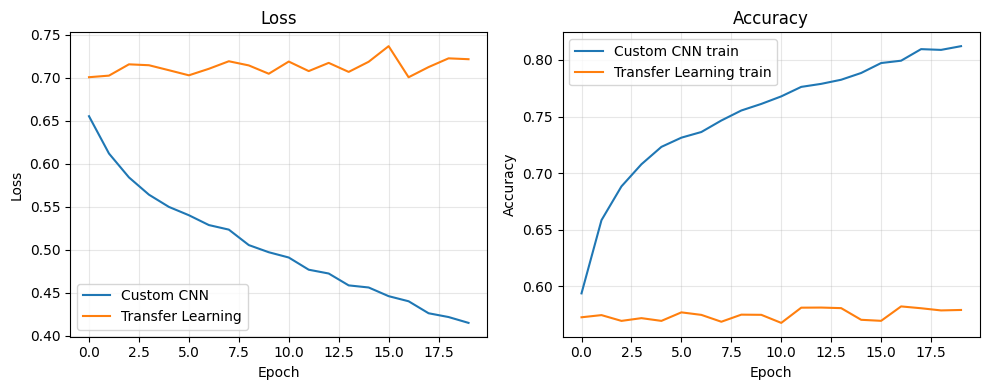

In [147]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(custom_cnn.history.history["loss"], label="Custom CNN")
if "val_loss" in custom_cnn.history.history:
    plt.plot(custom_cnn.history.history["val_loss"], label="Custom CNN val", linestyle="--")
plt.plot(transfer_model.history.history["loss"], label="Transfer Learning")
if "val_loss" in transfer_model.history.history:
    plt.plot(transfer_model.history.history["val_loss"], label="Transfer Learning val", linestyle="--")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.subplot(1, 2, 2)
if "accuracy" in custom_cnn.history.history:
    plt.plot(custom_cnn.history.history["accuracy"], label="Custom CNN train")
if "val_accuracy" in custom_cnn.history.history:
    plt.plot(custom_cnn.history.history["val_accuracy"], label="Custom CNN val", linestyle="--")
if "accuracy" in transfer_model.history.history:
    plt.plot(transfer_model.history.history["accuracy"], label="Transfer Learning train")
if "val_accuracy" in transfer_model.history.history:
    plt.plot(transfer_model.history.history["val_accuracy"], label="Transfer Learning val", linestyle="--")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


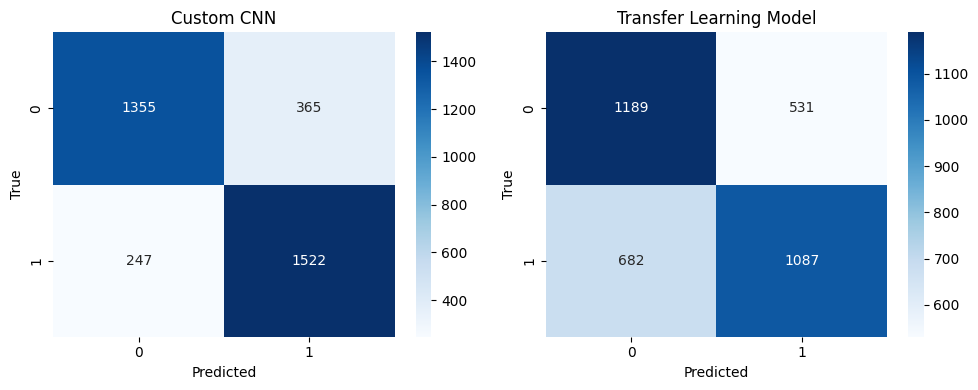

In [148]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(custom_cnn_confusion_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Custom CNN")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(tf_cm, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title("Transfer Learning Model")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()


In [149]:
analysis_text = """
TODO: Write your analysis here (maximum 200 words guideline)

Address:
1. Which model performed better and by how much?
   The custom CNN clearly performed better: accuracy 0.8246 vs 0.6363 (~+0.19), precision 0.8262 vs 0.6365, recall 0.8241 vs 0.6358, F1 0.8242 vs 0.6355. This indicates a large and consistent performance gap in favour of the custom architecture.

2. Impact of pre-training vs training from scratch?
   Pre-training should give strong generic features and faster convergence, but frozen ResNet50 backbone did not transfer well the dataset. The custom CNN learned task-specific filters that generalised better.

3. Effect of Global Average Pooling?
   GAP drastically reduces parameters by replacing large flatten+dense layers with a single pooling operation. This acts as a built-in regulariser that tends to reduce overfitting,  but it could not fully compensate for the domain/architecture mismatch.

4. Computational cost comparison?
   The transfer model has ~2.41*10⁷ parameters vs ~9.35*10⁴ for the custom CNN (≈258x larger)

5. Insights about transfer learning?
   Transfer learning is best when you have limited data, images similar to the pre-training domain and good‑enough performance. A custom CNN is prefered for a compact model tailored and empirically performs better on the specific dataset.
"""

In [150]:
# REQUIRED: Print analysis with word count
print("ANALYSIS")
print(analysis_text)
print(f"Analysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) > 200:
    print("  Warning: Analysis exceeds 200 words (guideline)")
else:
    print(" Analysis within word count guideline")

ANALYSIS

TODO: Write your analysis here (maximum 200 words guideline)

Address:
1. Which model performed better and by how much?
   The custom CNN clearly performed better: accuracy 0.8246 vs 0.6363 (~+0.19), precision 0.8262 vs 0.6365, recall 0.8241 vs 0.6358, F1 0.8242 vs 0.6355. This indicates a large and consistent performance gap in favour of the custom architecture.

2. Impact of pre-training vs training from scratch?
   Pre-training should give strong generic features and faster convergence, but frozen ResNet50 backbone did not transfer well the dataset. The custom CNN learned task-specific filters that generalised better.

3. Effect of Global Average Pooling?
   GAP drastically reduces parameters by replacing large flatten+dense layers with a single pooling operation. This acts as a built-in regulariser that tends to reduce overfitting,  but it could not fully compensate for the domain/architecture mismatch.

4. Computational cost comparison?
   The transfer model has ~2.41*10

In [151]:
def get_assignment_results():
    """
    Generate complete assignment results in required format
    
    Returns:
        dict: Complete results with all required fields
    """
    
    framework_used = "keras"  # TODO: Change to "pytorch" if using PyTorch
    
    results = {
        # Dataset Information
        'dataset_name': dataset_name,
        'dataset_source': dataset_source,
        'n_samples': n_samples,
        'n_classes': n_classes,
        'samples_per_class': samples_per_class,
        'image_shape': image_shape,
        'problem_type': problem_type,
        'primary_metric': primary_metric,
        'metric_justification': metric_justification,
        'train_samples': train_samples,
        'test_samples': test_samples,
        'train_test_ratio': train_test_ratio,
        
        # Custom CNN Results
        'custom_cnn': {
            'framework': framework_used,
            'architecture': {
                'conv_layers': len([layer for layer in custom_cnn.layers if isinstance(layer, layers.Conv2D)]),
                'pooling_layers': len([layer for layer in custom_cnn.layers if isinstance(layer, layers.MaxPooling2D)]),
                'has_global_average_pooling': True,  # MUST be True
                'output_layer': 'softmax',
                'total_parameters': custom_cnn.count_params()
            },
            'training_config': {
                'learning_rate': custom_cnn_learning_rate,  # TODO: Your actual learning rate
                'n_epochs': custom_cnn_epochs,  # TODO: Your actual epochs
                'batch_size': custom_cnn_batch_size,  # TODO: Your actual batch size
                'optimizer': custom_cnn_optimizer,  # TODO: Your actual optimizer
                'loss_function': custom_cnn_loss  # TODO: Your actual loss
            },
            'initial_loss': custom_cnn_initial_loss,
            'final_loss': custom_cnn_final_loss,
            'training_time_seconds': custom_cnn_training_time,
            'accuracy': custom_cnn_accuracy,
            'precision': custom_cnn_precision,
            'recall': custom_cnn_recall,
            'f1_score': custom_cnn_f1
        },
        
        # Transfer Learning Results
        'transfer_learning': {
            'framework': framework_used,
            'base_model': pretrained_model_name,
            'frozen_layers': frozen_layers,
            'trainable_layers': trainable_layers,
            'has_global_average_pooling': True,  # MUST be True
            'total_parameters': transfer_model.count_params(),
            'trainable_parameters': trainable_parameters,
            'training_config': {
                'learning_rate': tl_learning_rate,
                'n_epochs': tl_epochs,
                'batch_size': tl_batch_size,
                'optimizer': tl_optimizer,
                'loss_function': transfer_model_loss
            },
            'initial_loss': tl_initial_loss,
            'final_loss': tl_final_loss,
            'training_time_seconds': tl_training_time,
            'accuracy': tl_accuracy,
            'precision': tl_precision,
            'recall': tl_recall,
            'f1_score': tl_f1
        },
        
        # Analysis
        'analysis': analysis_text,
        'analysis_word_count': len(analysis_text.split()),
        
        # Training Success Indicators
        'custom_cnn_loss_decreased': custom_cnn_final_loss < custom_cnn_initial_loss if custom_cnn_initial_loss and custom_cnn_final_loss else False,
        'transfer_learning_loss_decreased': tl_final_loss < tl_initial_loss if tl_initial_loss and tl_final_loss else False,
    }
    
    return results

In [152]:
# Generate and print results
try:
    assignment_results = get_assignment_results() 
    print("ASSIGNMENT RESULTS SUMMARY")
    print(json.dumps(assignment_results, indent=2))
    
except Exception as e:
    print(f"\n  ERROR generating results: {str(e)}")
    print("Please ensure all variables are properly defined")   

ASSIGNMENT RESULTS SUMMARY
{
  "dataset_name": "Cats VS Dogs",
  "dataset_source": "Tensorflow datasets",
  "n_samples": 23262,
  "n_classes": 2,
  "samples_per_class": "min: 9835, max: 9938, avg: 9886.5",
  "image_shape": [
    224,
    224,
    3
  ],
  "problem_type": "classification",
  "primary_metric": "accuracy",
  "metric_justification": "Accuracy is chosen because this is a balanced, binary classification problem where both classes have representation and the typical misclassification costs are symmetric. accuracy therefore gives a direct measure of overall correctness",
  "train_samples": 19773,
  "test_samples": 3489,
  "train_test_ratio": "85/15",
  "custom_cnn": {
    "framework": "keras",
    "architecture": {
      "conv_layers": 3,
      "pooling_layers": 3,
      "has_global_average_pooling": true,
      "output_layer": "softmax",
      "total_parameters": 93506
    },
    "training_config": {
      "learning_rate": 0.001,
      "n_epochs": 20,
      "batch_size": 32,


In [153]:
# Display system information
import platform
import sys
from datetime import datetime

In [154]:
print("ENVIRONMENT INFORMATION")
print("\n  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab")
print("showing your account details in the cell below this one.")

# include the screen shot here

ENVIRONMENT INFORMATION

  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab
showing your account details in the cell below this one.
